In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import re

# Problem 1

In [63]:
mu1 = np.array([0,0])
mu2 = np.array([3,0])
mu3 = np.array([0, 3])
sigma = np.array([[1, 0],[0, 1]])
pi = [0.2,0.5,0.3]

In [64]:
idx = np.random.choice(3, 500, p = pi)
_, num = np.unique(idx, return_counts=True)
data = np.concatenate((np.random.multivariate_normal(mu1,sigma,num[0]),np.random.multivariate_normal(mu2,sigma,num[1]),np.random.multivariate_normal(mu3,sigma,num[2])))
#scipy.stats.multivariate_normal.rvs can also draw random samples from a multivariate normal distribution


## a)

In [40]:
def K_means(data, K, iteration):
    """
    Calculate the objective function of K-means
    Parameters:
        data: input data, shape of data is (#samples, #dimensions)
        K: number of K
        iteration: number of iterations
    Return:
        L: objective function
        cluster: dataframe, indicate which cluster a data point belongs to
    """
    mu_all = np.random.random((K,data.shape[1]))
    objective_function = []
    for ite in range(iteration):
        dist_all = {}
        L = 0
        for i in range(0,len(mu_all)):
            #dist_all[i] = np.linalg.norm(data - mu_all[i],axis = 1)  #another way to calculate Euclidean distance (already root)
            dist_all[i] = np.sum(np.square(data - mu_all[i]),axis = 1)  #square can be replaced by **2; **2 is faster            
        dist_all = pd.DataFrame(dist_all)
        dist_all['muk'] = dist_all.idxmin(axis = 1)
        for i in range(0, len(mu_all)):
            index = dist_all.loc[dist_all.loc[:,'muk'] == i].index
            L = L + sum(dist_all.iloc[index,i])   #update objective function
            mu_all[i] = np.sum(data[index],axis = 0)/len(index)  #update mu
        objective_function.append(L)
    cluster = dist_all.loc[:,'muk':]
    return objective_function, cluster    

In [5]:
K = [2,3,4,5]
objective_function_value = {}
for k in K:
    objective_function_value[k],_ = K_means(data,k,20)

In [6]:
objective_function_value = pd.DataFrame(objective_function_value, columns=K)

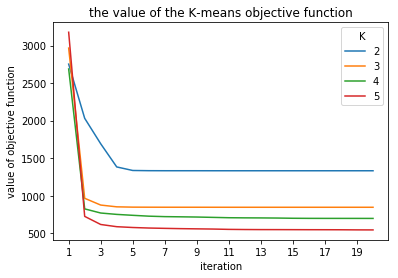

In [7]:
objective_function_value.plot()
plt.xlabel('iteration')
plt.ylabel('value of objective function')
plt.title('the value of the K-means objective function')
plt.xticks(np.arange(0,20,2),np.arange(1,21,2))
plt.legend(title = 'K')

## b)

In [45]:
def K_means_plot(data,K, iteration):
    """
    Plot the cluster after final iteration of K-means
    Parameters:
        data: data
        K: number of K
        iteration: number of iterations
    Returns:
        plot of data after clustering by K-means
    """
    _, cluster_index =  K_means(data, K, iteration)
    clusters = pd.concat([pd.DataFrame(data),cluster_index],axis = 1)
    clusters.columns = ['X','y','k']
    sns.lmplot(x ='X', y = 'y' , hue = 'k', data = clusters, fit_reg=False, legend_out=True)

### When k = 3:

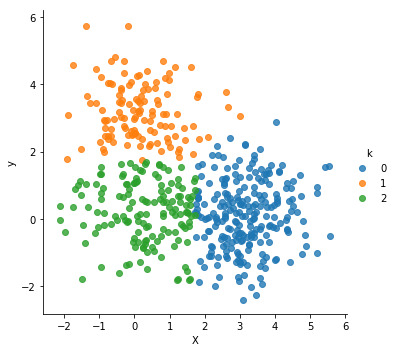

In [46]:
K_means_plot(data,3,20)

### When k = 5:

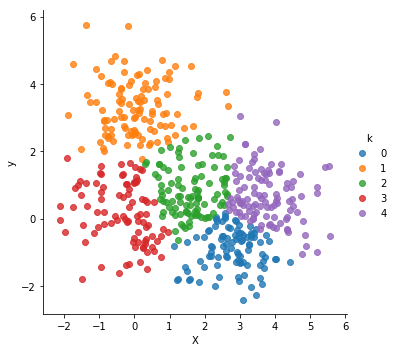

In [48]:
K_means_plot(data,5,20)

# Problem 2

In [473]:
X_train = pd.read_csv('hw3-data/Prob2_Xtrain.csv', header = None)
X_test = pd.read_csv('hw3-data/Prob2_Xtest.csv', header = None)
y_train = pd.read_csv('hw3-data/Prob2_ytrain.csv', header = None)
y_test = pd.read_csv('hw3-data/Prob2_ytest.csv', header = None)

## a)

In [483]:
def GMM(X, k, iteration):
    """
    Use guassian mixture model to cluster the data and return the value of log marginal objective function
    Parameters:
        X: input data, dataframe
        k: number of clusters, int, >=1
        iteration: number of iterations, int
    Returns:
        objective function: value of log marginal objective function
    """
    #initialize
    objective_function = []
    n = X.shape[0]
    X = np.array(X)
    pi = np.ones(k)*(1/k)
    cov = np.cov(X.T)   #cov is the intialized covariance of kth guassian distribution
    sigma = [cov]*k    #sigma is the parameter Sigma of Guassin mixture model
    mean  = np.mean(X, axis = 0)  
    mu =np.random.multivariate_normal(mean = mean, cov=cov, size = k)      #mu is the parameter Mu of Guassian mixture model
    
    for ite in range(iteration):
        #E-step
        s = 0
        phi = [0] * k
        for i in range(0,k):
            s = multivariate_normal.pdf(X, mean = mu[i], cov=sigma[i],allow_singular=True)*pi[i] + s
        for i in range(0,k):
            phi[i] = (multivariate_normal.pdf(X, mean = mu[i], cov=sigma[i],allow_singular=True)*pi[i]/s)
        #M-step
        n_k = np.zeros(k)
        for i in range(0,k):
            n_k[i] = np.sum(phi[i])
        pi = n_k/n
        for i in range(0,k):
            mu[i] = np.sum(np.multiply(phi[i].reshape(n,-1),X),axis=0)/n_k[i]
        for i in range(0,k):
            temp = np.multiply(phi[i].reshape(n,-1),X - mu[i])
            sigma[i] = np.dot((X - mu[i]).T, temp)/n_k[i]
        L = np.sum(np.log(s))
        objective_function.append(L)
    return objective_function, pi, mu, sigma

In [509]:
def objective_function_GMM(X, y, k, runs, iterations):
    """
    Plot the objective function of Guassian mixture model of each class, data need to be labeled
    Parameters:
        X: X, dataframe
        y: label, dataframe
        k: number of cluster, int
        runs: number of runs, int
        iterations: number of iterations to be plotted, list
    Returns:
        pi_best: best pi in runs
        mu_best: best mu in runs
        sigma_best: best sigma in runs
        objective function： the objective function value of Guassian mixture model in the traning process
    """
    y.columns = ['y']
    data = pd.concat([X,y],axis = 1)
    values = np.unique(y.values)
    objective_function = {}
    pis = {}
    mus = {}
    sigmas = {}
    pi_best = {}
    mu_best = {}
    sigma_best = {}
    for value in values:
        X = data.loc[data['y'] == value]
        X = X.iloc[:,:-1]
        runs = 10
        objective_function[value] = []
        pis[value] = []
        mus[value] = []
        sigmas[value] = []
        for run in range(runs):
            L, pi, mu, sigma = GMM(X,k,iterations[-1])
            objective_function[value].append(L)
            pis[value].append(pi)
            mus[value].append(mu)
            sigmas[value].append(sigma)
        
        idx = pd.DataFrame(objective_function[value]).iloc[:,-1].idxmax()
        pi_best[value] = pis[value][idx]
        mu_best[value] = mus[value][idx]
        sigma_best[value] = sigmas[value][idx]
    return pi_best,mu_best,sigma_best,objective_function

In [510]:
runs = 10
iterations = list(range(5,31))
pi_best, mu_best, sigma_best,objective_function_value = objective_function_GMM(X_train,y_train,3,runs,iterations)

In [511]:
def objective_function_plot(objective_function_value, runs, iterations):
    """
    Plot the value of objective function in iterations of every run
    Parameters:
        objective_function_value: the value of objective_function, list of numpy array
        runs: number of runs, int
        iterations: number of iterations to be plotted, list
    Returns:
        plot of value of objective function
    """
    values = objective_function_value.keys()
    for value in values:
        data_plot = pd.DataFrame(objective_function_value[value], index = list(range(1,runs+1)), columns=list(range(1,iterations[-1]+1))).T.loc[iterations,:]
        data_plot.plot()
        plt.title("objective function of class "+str(value))
        plt.xlabel("iteration")
        

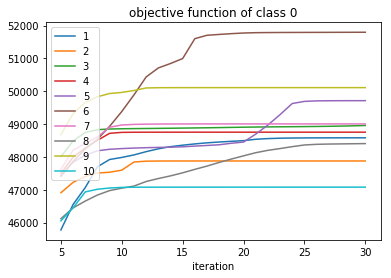

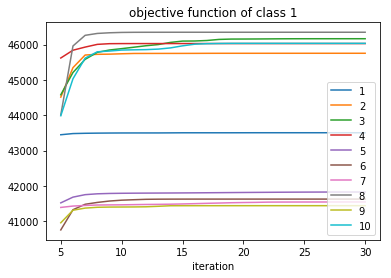

In [512]:
objective_function_plot(objective_function_value, runs, iterations)

## b)

In [513]:
def confusion_matrix(y_pred, y_test):
    """ 
    Calculate TP, FP, FN and TN in confusion matrix
    this method can only deal with binary classficiation(when y=0/1 or when y = -1/+1)
    Parameters:
        y_pred: numpy array
        y_test: numpy array
        they must be of same shape(n,1)
    Returns:
        TP: y_pred = 1 and y_test = 1
        FP: y_pred = 1 and y_test = 0
        FN: y_pred = 0 and y_test = 1
        TN: y_pred = 0 and y_test = 0
    """
    if y_pred.shape[0]!=y_test.shape[0]:
        raise ValueError("two dataframe must have the same length!")
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    y_pred = np.where(y_pred==-1, 0, y_pred)
    y_test = np.where(y_test==-1, 0, y_test)
    for i in range(y_pred.shape[0]):
        if y_pred[i]== 1 and y_test[i]==1:
            TP = TP+1
        elif y_pred[i]== 1 and y_test[i]==0:
            FP = FP+1
        elif y_pred[i]== 0 and y_test[i]==1:
            FN = FN+1
        elif y_pred[i]== 0 and y_test[i]==0:
            TN = TN+1
        else:
            raise ValueError("please limit the value of y to 0 and 1")
    confusion_matrix_value = [[TP,FP],[FN,TN]]
    accuracy = (TP+TN)/(TP+TN+FP+FN) 
    print ("confusion matrix: ")
    print(pd.DataFrame(confusion_matrix_value, index=['True','False'],columns=['True','False']))
    print ('----------------')
    print ("accuracy: ", accuracy)

In [514]:
def Bayes_Classifier_GMM(X_train, y_train, X_test,k,pi,mu,sigma):
    """
    Use bayes classifier to predict, and assume that X|y ~ GMM(k, pi, mu, sigma)
    Parameters:
        X_train: dataframe
        y_train: dataframe
        X_test: dataframe
        k: number of cluster in GMM
        pi, mu, sigma: parameter of GMM, dict
    Returns: 
        y_pred: prediction od y on X_test
    """
    pi = list(pi.values())
    mu = list(mu.values())
    sigma = list(sigma.values())
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    p = np.bincount(y_train.flatten())/y_train.shape[0]    #since it is a classification problem, assume y ~ Bernoulli(p)
    prob = [0]*len(p)

    for i in range(0,len(p)):
        for j in range(0,k):
            prob[i] = multivariate_normal.pdf(X_test, mu[i][j], sigma[i][j],allow_singular=True)*pi[i][j]*p[i]+prob[i]
    y_pred= pd.DataFrame(prob).idxmax(axis = 0).values
    return y_pred


In [515]:
confusion_matrix(Bayes_Classifier_GMM(X_train,y_train,X_test,3,pi_best,mu_best,sigma_best),y_test)

confusion matrix: 
       True  False
True    167     50
False    15    228
----------------
accuracy:  0.8586956521739131


In [518]:
for k in range(1,5):
    print (str(k)+"-Guassian Mixture Model")
    pi_best, mu_best, sigma_best,_ = objective_function_GMM(X_train,y_train,k,runs,iterations)
    confusion_matrix(Bayes_Classifier_GMM(X_train,y_train,X_test,k,pi_best,mu_best,sigma_best),y_test)
    print ('\n')

1-Guassian Mixture Model
confusion matrix: 
       True  False
True    174     96
False     8    182
----------------
accuracy:  0.7739130434782608


2-Guassian Mixture Model
confusion matrix: 
       True  False
True    173     83
False     9    195
----------------
accuracy:  0.8


3-Guassian Mixture Model
confusion matrix: 
       True  False
True    169     47
False    13    231
----------------
accuracy:  0.8695652173913043


4-Guassian Mixture Model
confusion matrix: 
       True  False
True    174     63
False     8    215
----------------
accuracy:  0.8456521739130435




# Problem 3

## a)

In [3]:
train_data = pd.read_csv("hw3-data/Prob3_ratings.csv",header = None)
test_data = pd.read_csv("hw3-data/Prob3_ratings_test.csv",header = None)
train_data.columns = ['user_id','item_id','rating']
test_data.columns = ['user_id','item_id','rating']

In [202]:
def construct_matrix(train,test):
    """
    Return the user_item matrix
    Parameters: 
        train: dataframe, columns are 'user_id','item_id','rating'
        test: dataframe, columns are 'user_id','item_id','rating'
    Returns: 
        train_matrix: matrix of train dataset
        test_matrix: matrix of test dataset
    """
    train_user_ids = train.loc[:,'user_id'].unique()
    train_item_ids = train.loc[:,'item_id'].unique()
    test_user_ids = test.loc[:,'user_id'].unique()
    test_item_ids = test.loc[:,'item_id'].unique()
    
    user_ids = list(set(train_user_ids)|set(test_user_ids))   #user_id: 1-943
    item_ids = list(set(train_item_ids)|set(test_item_ids))   #item_id: 1-1682
    user_ids = pd.DataFrame(user_ids)
    user_ids.columns=['user_id']
    item_ids = pd.DataFrame(item_ids)
    item_ids.columns=['item_id']
    
    train = train.join(user_ids.set_index('user_id'), on='user_id',how='outer')
    train = train.join(item_ids.set_index('item_id'), on='item_id',how='outer')
    train = train.pivot(*train.columns)
    train = train.loc[user_ids.values.flatten(),item_ids.values.flatten()]
    train_matrix = np.array(train)
    
    test = test.join(user_ids.set_index('user_id'), on='user_id',how='outer')
    test = test.join(item_ids.set_index('item_id'), on='item_id',how='outer')
    test = test.pivot(*test.columns)
    test = test.loc[user_ids.values.flatten(),item_ids.values.flatten()]
    test_matrix = np.array(test)
    
    return train_matrix, test_matrix

In [315]:
train, test = construct_matrix(train_data,test_data)

In [216]:
def matrix_factorization(data,sigma_sqaured, d, lambda_, iterations, runs = 1):
    """
    Implement matrix factorization
    Parameters:
        data: dataframe, user-item matrix
        sigma_squared: covariance of Guassian distribution of M
        d: the rank of u and v
        lambda_: parameter in Guassian distribution of u and v
        iterations: number of iterations
        runs: number of runs, default = 1
    Returns:
        objective_function: the value of log likelihood in iterations    
        u: the value of matrix U
        v: the value of matrix v
    """
    N1 = data.shape[0]
    N2 = data.shape[1]
    
    data[np.isnan(data)] = 0  # there is no 0 in original dataset
    
    objective_functions  = {}
    U = {}
    V = {}
    
    for run in range(0,runs):
        #initialize   
        v = np.random.multivariate_normal(np.repeat(0,d),np.identity(d)/lambda_,N2).T  #this is matrix v
        u = np.repeat(np.NaN,N1*d).reshape(N1, d)   # this is matrix u
        objective_function = []
        for iteration in range(0,iterations):
            for i in range(0,N1):
                temp = np.multiply(abs(np.sign(data[i])),v)
                temp = np.dot(temp,temp.T)
                temp = temp+np.identity(d)*lambda_*sigma_sqaured
                temp = np.linalg.inv(temp)
                #temp2 =   np.dot(v,data[i])#10*1
                u[i] = np.dot(temp,np.dot(v,data[i]))

            for j in range(0,N2):
                temp = np.multiply(abs(np.sign(data[:,j])).reshape(N1,-1),u)
                temp = np.dot(temp.T,temp)
                temp = temp+np.identity(d)*lambda_*sigma_sqaured
                temp = np.linalg.inv(temp)
                v[:,j] = np.dot(temp,np.dot(u.T,data[:,j]))

            residual = np.multiply(data - np.dot(u,v),abs(np.sign(data)))
            L = -np.sum(np.square(residual))/(2*sigma_sqaured)-np.sum(np.square(u))-np.sum(np.square(v)) #忘了+constant
            objective_function.append(L)
        objective_functions['run '+str(run+1)] = objective_function   
        U['run '+str(run+1)] = u
        V['run '+str(run+1)] = v
        
    return objective_functions, U, V

In [217]:
L, U, V = matrix_factorization(train,0.25,10,1,100,10)

Text(0.5, 1.0, 'log join likelihood')

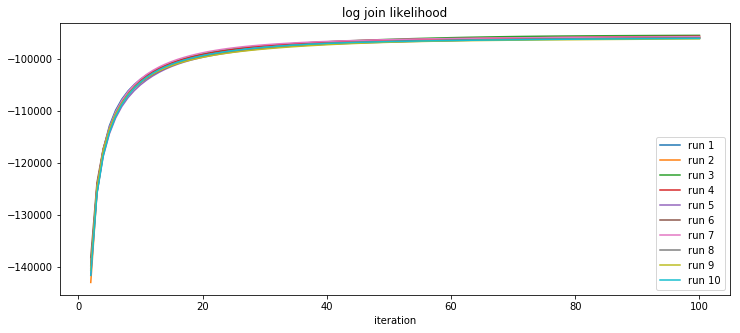

In [237]:
L = pd.DataFrame(L)
L.index = list(range(1,101))
L.loc[2:].plot(figsize = (12,5))
plt.xlabel('iteration')
plt.title('log join likelihood')

In [303]:
def rmse_calculate(test,pred):
    """
    calculate the RMSE on the test set
    Parameters:
        test: numpy matrix
        pred: numpy matrix
    Returns:
        RMSE
    """
    n = np.sum(abs(np.sign(test)))
    residual = np.multiply(test - pred,abs(np.sign(test)))
    RMSE = np.sqrt(np.sum(np.square(residual))/n)
                  
    return RMSE

In [304]:
def rmse_matrix_factorization(test, U, V):
    """
    Calculate the RMSE of matrix factorization
    Parameters:
        test: test dataset, matrix like
        U: U matrix of several runs
        V: V matrix of several runs
    Returns: 
        RMSE: RMSE of several runs
    """
    test[np.isnan(test)] = 0
    
    RMSEs = {}
    for (value1, value2) in zip(U.items(), V.items()):
        RMSEs[value1[0]] = rmse_calculate(test, np.dot(value1[1],value2[1]))
    return RMSEs

In [305]:
rmse  = rmse_matrix_factorization(test, U, V)

In [306]:
rmse = pd.DataFrame.from_dict(rmse, orient='index')
rmse.columns = ['RMSE on the testing set']

In [307]:
final_objective_function = L.iloc[-1:,:]
final_objective_function = final_objective_function.T
final_objective_function.columns = ['final value of the training objective function']

In [346]:
res = pd.concat([rmse, final_objective_function],axis = 1)
res

,RMSE on the testing set,final value of the training objective function
run 1,1.126845,-95954.506628
run 2,1.126796,-95806.575638
run 3,1.111083,-95425.129857
run 4,1.112870,-95596.113692
run 5,1.117052,-95940.047972
run 6,1.104386,-95875.968274
run 7,1.121637,-95674.125542
run 8,1.097887,-95907.088272
run 9,1.090341,-96106.900382
run 10,1.106541,-96010.292593


## b)

In [425]:
movies = [line.strip() for line in open('hw3-data/Prob3_movies.txt')]

In [349]:
best_run = res.loc[:,'final value of the training objective function'].idxmax()
v = V[best_run]

In [416]:
def find_the_closest_item(V, item_index, n):
    """
    Given the item index, find the n closet item
    Parameters:
        V: item matrix, shape d*number of items
        item_index: int, the index of item 
        n: number of closest items
    Returns:
        indexes: indexes of n closest items
        distances: distances of n closest items
    """
    temp = V.T- V.T[item_index]
    temp = np.sqrt(np.sum(np.square(temp),axis = 1))
    indexes = temp.argsort()[1:n+1]
    distances = []
    
    for index in indexes:
        distances.append(temp[index])
    
    return indexes, distances

In [471]:
def find_closest_movies(V, movies_name,movies_map, n):
    """
    Given the name of movies, find the n nearest movie and their distances
    Parameters:
        V: item matrix, shape d*number of items
        movies_names: a list of the name of query movies
        movies_map: mapping from index to movie
        n: number of closest movies
    Returns:
        print a table showing the query movie, the ten nearest movies and their distances.
    """
    for movie in movies_name:
        i = np.NaN
        for i in range(0,len(movies_map)):
            if re.search(movie,movies_map[i],flags=re.I) != None:  #ignore case 
                item_index = i
                break;
        if i==np.NaN:
            print ("No such movie")
            break;
            
        closest_index, closest_distance  = find_the_closest_item(V, item_index, n)
        closest_name = []
        for index in closest_index:
            closest_name.append(movies[index])
            
        print ("query movie: ", movie)
        closest_name = pd.DataFrame(closest_name, columns= ['movie name'])
        closest_distance = pd.DataFrame(closest_distance, columns= ['Euclidean distance'])
        closest_movies = pd.concat([closest_name,closest_distance],axis = 1)
        print (closest_movies)
        print ('\n')

In [472]:
find_closest_movies(v,['Star Wars', 'My Fair Lady', 'Goodfellas'] ,movies, 10)

query movie:  Star Wars
                                  movie name  Euclidean distance
0            Empire Strikes Back, The (1980)            0.110964
1             Raiders of the Lost Ark (1981)            0.385319
2                  Return of the Jedi (1983)            0.461393
3                 Princess Bride, The (1987)            0.564981
4                 Usual Suspects, The (1995)            0.738527
5                 Blues Brothers, The (1980)            0.762079
6  Indiana Jones and the Last Crusade (1989)            0.816979
7               Love in the Afternoon (1957)            0.874951
8                 Wrong Trousers, The (1993)            0.913773
9      Day the Earth Stood Still, The (1951)            0.934794


query movie:  My Fair Lady
                                          movie name  Euclidean distance
0                          Gone with the Wind (1939)            0.742714
1                                     Sabrina (1954)            0.884437
2            